# Definizione Schema Mediato

Questo notebook definisce uno schema mediato per integrare i due dataset di auto usate:
1. **Dataset Craigslist** - dati da Craigslist Cars & Trucks
2. **Dataset Used Cars** - dati US Used Cars

## Obiettivo
Creare uno schema unificato che integri gli attributi comuni e complementari dei due dataset, definendo:
- Corrispondenze (mapping) tra gli attributi
- Schema target mediato
- Trasformazioni necessarie per l'integrazione

## 1. Import delle Librerie e Caricamento Dati

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime

# Caricamento dataset
df_craigslist = pd.read_csv('dataset/craigslist.csv')
df_used_cars = pd.read_csv('dataset/used_cars.csv')

print("Dataset Craigslist:")
print(f"  Righe: {len(df_craigslist):,}, Colonne: {len(df_craigslist.columns)}")
print(f"\nDataset Used Cars:")
print(f"  Righe: {len(df_used_cars):,}, Colonne: {len(df_used_cars.columns)}")

C:\Users\migli\AppData\Local\Temp\ipykernel_13468\3313206372.py:7: DtypeWarning: Columns (0: dealer_zip) have mixed types. Specify dtype option on import or set low_memory=False.
  df_used_cars = pd.read_csv('dataset/used_cars.csv')


Dataset Craigslist:
  Righe: 426,880, Colonne: 26

Dataset Used Cars:
  Righe: 3,000,040, Colonne: 66


## 2. Analisi Attributi dei Dataset

In [28]:
# Mostra tutti gli attributi senza limitazioni
pd.set_option('display.max_rows', None)

print("ATTRIBUTI DATASET CRAIGSLIST:")
print("=" * 80)
print(f"Totale attributi: {len(df_craigslist.columns)}\n")
for i, col in enumerate(df_craigslist.columns, 1):
    print(f"{i:2d}. {col} ({df_craigslist[col].dtype})")

ATTRIBUTI DATASET CRAIGSLIST:
Totale attributi: 26

 1. id (int64)
 2. url (str)
 3. region (str)
 4. region_url (str)
 5. price (int64)
 6. year (float64)
 7. manufacturer (str)
 8. model (str)
 9. condition (str)
10. cylinders (str)
11. fuel (str)
12. odometer (float64)
13. title_status (str)
14. transmission (str)
15. VIN (str)
16. drive (str)
17. size (str)
18. type (str)
19. paint_color (str)
20. image_url (str)
21. description (str)
22. county (float64)
23. state (str)
24. lat (float64)
25. long (float64)
26. posting_date (str)


In [29]:
print("\n\nATTRIBUTI DATASET USED CARS:")
print("=" * 80)
print(f"Totale attributi: {len(df_used_cars.columns)}\n")
for i, col in enumerate(df_used_cars.columns, 1):
    print(f"{i:2d}. {col} ({df_used_cars[col].dtype})")



ATTRIBUTI DATASET USED CARS:
Totale attributi: 66

 1. vin (str)
 2. back_legroom (str)
 3. bed (str)
 4. bed_height (str)
 5. bed_length (str)
 6. body_type (str)
 7. cabin (str)
 8. city (str)
 9. city_fuel_economy (float64)
10. combine_fuel_economy (float64)
11. daysonmarket (int64)
12. dealer_zip (object)
13. description (str)
14. engine_cylinders (str)
15. engine_displacement (float64)
16. engine_type (str)
17. exterior_color (str)
18. fleet (object)
19. frame_damaged (object)
20. franchise_dealer (bool)
21. franchise_make (str)
22. front_legroom (str)
23. fuel_tank_volume (str)
24. fuel_type (str)
25. has_accidents (object)
26. height (str)
27. highway_fuel_economy (float64)
28. horsepower (float64)
29. interior_color (str)
30. isCab (object)
31. is_certified (float64)
32. is_cpo (object)
33. is_new (bool)
34. is_oemcpo (object)
35. latitude (float64)
36. length (str)
37. listed_date (str)
38. listing_color (str)
39. listing_id (int64)
40. longitude (float64)
41. main_picture_u

## 3. Definizione Mapping tra Attributi

Identifichiamo le corrispondenze tra gli attributi dei due dataset

In [30]:
# Definizione mapping: { 'attributo_mediato': ('craigslist_attr', 'used_cars_attr') }
attribute_mapping = {
    # Attributi di identificazione
    'vehicle_id': ('id', 'listing_id'),
    'vin': ('VIN', 'vin'),
    
    # Informazioni base veicolo
    'price': ('price', 'price'),
    'year': ('year', 'year'),
    'manufacturer': ('manufacturer', 'make_name'),
    'model': ('model', 'model_name'),
    
    # Caratteristiche tecniche
    'mileage': ('odometer', 'mileage'),
    'fuel_type': ('fuel', 'fuel_type'),
    'transmission': ('transmission', 'transmission'),
    'cylinders': ('cylinders', 'engine_cylinders'),
    'drive_type': ('drive', 'wheel_system'),
    
    # Caratteristiche fisiche
    'body_type': ('type', 'body_type'),
    'exterior_color': ('paint_color', 'exterior_color'),
    'condition': ('condition', None),  # Solo Craigslist
    'size': ('size', None),  # Solo Craigslist
    
    # Informazioni geografiche
    'latitude': ('lat', 'latitude'),
    'longitude': ('long', 'longitude'),
    'location': ('region', 'city'),
    'state': ('state', None),  # Solo Craigslist
    
    # Informazioni venditore
    'listing_date': ('posting_date', 'listed_date'),
    'description': ('description', 'description'),
    'image_url': ('image_url', 'main_picture_url'),
    'title_status': ('title_status', None),  # Solo Craigslist
    
    # Attributi specifici Used Cars
    'dealer_info': (None, 'sp_name'),
    'horsepower': (None, 'horsepower'),
    'seller_rating': (None, 'seller_rating'),
    'days_on_market': (None, 'daysonmarket'),
    'is_new': (None, 'is_new'),
    'has_accidents': (None, 'has_accidents'),
}

print("MAPPING ATTRIBUTI DEFINITO:")
print("=" * 80)
print(f"Totale attributi mediati: {len(attribute_mapping)}")
print(f"\nDettaglio mapping:")
for mediated_attr, (craigslist_attr, used_cars_attr) in attribute_mapping.items():
    c_attr = craigslist_attr if craigslist_attr else "---"
    u_attr = used_cars_attr if used_cars_attr else "---"
    print(f"  {mediated_attr:20s} <- Craigslist: {c_attr:20s} | Used Cars: {u_attr:20s}")

MAPPING ATTRIBUTI DEFINITO:
Totale attributi mediati: 29

Dettaglio mapping:
  vehicle_id           <- Craigslist: id                   | Used Cars: listing_id          
  vin                  <- Craigslist: VIN                  | Used Cars: vin                 
  price                <- Craigslist: price                | Used Cars: price               
  year                 <- Craigslist: year                 | Used Cars: year                
  manufacturer         <- Craigslist: manufacturer         | Used Cars: make_name           
  model                <- Craigslist: model                | Used Cars: model_name          
  mileage              <- Craigslist: odometer             | Used Cars: mileage             
  fuel_type            <- Craigslist: fuel                 | Used Cars: fuel_type           
  transmission         <- Craigslist: transmission         | Used Cars: transmission        
  cylinders            <- Craigslist: cylinders            | Used Cars: engine_cylinde

## 4. Definizione Schema Mediato

Lo schema mediato include tutti gli attributi selezionati con i rispettivi tipi di dati

In [31]:
# Definizione schema mediato con tipi di dati
mediated_schema = {
    'vehicle_id': 'string',
    'vin': 'string',
    'source_dataset': 'string',  # 'craigslist' o 'used_cars'
    
    # Informazioni base
    'price': 'float64',
    'year': 'int64',
    'manufacturer': 'string',
    'model': 'string',
    
    # Caratteristiche tecniche
    'mileage': 'float64',
    'fuel_type': 'string',
    'transmission': 'string',
    'cylinders': 'string',
    'drive_type': 'string',
    'horsepower': 'float64',
    
    # Caratteristiche fisiche
    'body_type': 'string',
    'exterior_color': 'string',
    'condition': 'string',
    'size': 'string',
    
    # Informazioni geografiche
    'latitude': 'float64',
    'longitude': 'float64',
    'location': 'string',
    'state': 'string',
    
    # Informazioni listing
    'listing_date': 'datetime64[ns]',
    'days_on_market': 'int64',
    'description': 'string',
    'image_url': 'string',
    
    # Informazioni venditore/titolo
    'dealer_info': 'string',
    'seller_rating': 'float64',
    'title_status': 'string',
    'is_new': 'bool',
    'has_accidents': 'bool',
}

# Creazione DataFrame con lo schema
schema_df = pd.DataFrame([
    {'Attributo': attr, 'Tipo': dtype, 'Descrizione': ''}
    for attr, dtype in mediated_schema.items()
])

# Aggiungi descrizioni
descriptions = {
    'vehicle_id': 'Identificatore unico del veicolo',
    'vin': 'Vehicle Identification Number',
    'source_dataset': 'Dataset di provenienza (craigslist/used_cars)',
    'price': 'Prezzo di vendita in USD',
    'year': 'Anno di produzione',
    'manufacturer': 'Casa produttrice',
    'model': 'Modello del veicolo',
    'mileage': 'Chilometraggio',
    'fuel_type': 'Tipo di carburante',
    'transmission': 'Tipo di trasmissione',
    'cylinders': 'Numero di cilindri',
    'drive_type': 'Tipo di trazione (4WD, FWD, RWD)',
    'horsepower': 'Potenza in cavalli',
    'body_type': 'Tipo di carrozzeria',
    'exterior_color': 'Colore esterno',
    'condition': 'Condizione del veicolo',
    'size': 'Dimensione del veicolo',
    'latitude': 'Latitudine posizione',
    'longitude': 'Longitudine posizione',
    'location': 'Città/Regione',
    'state': 'Stato (US)',
    'listing_date': 'Data di pubblicazione annuncio',
    'days_on_market': 'Giorni sul mercato',
    'description': 'Descrizione testuale',
    'image_url': 'URL immagine',
    'dealer_info': 'Informazioni venditore',
    'seller_rating': 'Valutazione venditore',
    'title_status': 'Stato del titolo di proprietà',
    'is_new': 'Veicolo nuovo/usato',
    'has_accidents': 'Presenza di incidenti',
}

schema_df['Descrizione'] = schema_df['Attributo'].map(descriptions)

print("SCHEMA MEDIATO DEFINITO:")
print("=" * 100)
print(f"Totale attributi: {len(mediated_schema)}")
print("\n")
display(schema_df)

SCHEMA MEDIATO DEFINITO:
Totale attributi: 30




,Attributo,Tipo,Descrizione
0,vehicle_id,string,Identificatore unico del veicolo
1,vin,string,Vehicle Identification Number
2,source_dataset,string,Dataset di provenienza (craigslist/used_cars)
3,price,float64,Prezzo di vendita in USD
4,year,int64,Anno di produzione
5,manufacturer,string,Casa produttrice
6,model,string,Modello del veicolo
7,mileage,float64,Chilometraggio
8,fuel_type,string,Tipo di carburante
9,transmission,string,Tipo di trasmissione


## 5. Verifica Mapping degli Attributi

Verifichiamo quali attributi sono coperti da ciascun dataset e la correttezza del mapping

In [32]:
# Analisi copertura
coverage_data = []

for mediated_attr, (craigslist_attr, used_cars_attr) in attribute_mapping.items():
    coverage_data.append({
        'Attributo Mediato': mediated_attr,
        'Craigslist': '✓' if craigslist_attr else '✗',
        'Used Cars': '✓' if used_cars_attr else '✗',
        'Sorgente Craigslist': craigslist_attr if craigslist_attr else '',
        'Sorgente Used Cars': used_cars_attr if used_cars_attr else ''
    })

coverage_df = pd.DataFrame(coverage_data)

print("COPERTURA ATTRIBUTI PER DATASET:")
print("=" * 100)
display(coverage_df)

# Statistiche
both = coverage_df[(coverage_df['Craigslist'] == '✓') & (coverage_df['Used Cars'] == '✓')]
only_craigslist = coverage_df[(coverage_df['Craigslist'] == '✓') & (coverage_df['Used Cars'] == '✗')]
only_used_cars = coverage_df[(coverage_df['Craigslist'] == '✗') & (coverage_df['Used Cars'] == '✓')]

print(f"\n\nSTATISTICHE COPERTURA:")
print(f"  Attributi presenti in entrambi i dataset: {len(both)}")
print(f"  Attributi solo in Craigslist: {len(only_craigslist)}")
print(f"  Attributi solo in Used Cars: {len(only_used_cars)}")
print(f"  Totale attributi mediati: {len(coverage_df)}")

COPERTURA ATTRIBUTI PER DATASET:


,Attributo Mediato,Craigslist,Used Cars,Sorgente Craigslist,Sorgente Used Cars
0,vehicle_id,✓,✓,id,listing_id
1,vin,✓,✓,VIN,vin
2,price,✓,✓,price,price
3,year,✓,✓,year,year
4,manufacturer,✓,✓,manufacturer,make_name
5,model,✓,✓,model,model_name
6,mileage,✓,✓,odometer,mileage
7,fuel_type,✓,✓,fuel,fuel_type
8,transmission,✓,✓,transmission,transmission
9,cylinders,✓,✓,cylinders,engine_cylinders




STATISTICHE COPERTURA:
  Attributi presenti in entrambi i dataset: 19
  Attributi solo in Craigslist: 4
  Attributi solo in Used Cars: 6
  Totale attributi mediati: 29


## 6. Allineamento Dataset Craigslist allo Schema Mediato

Trasformiamo il dataset Craigslist per adattarlo allo schema mediato

In [33]:
# Funzione per allineare Craigslist allo schema mediato (SOLO ATTRIBUTI COMUNI)
def align_craigslist_to_schema(df):
    """
    Allinea il dataset Craigslist allo schema mediato includendo SOLO gli attributi comuni:
    - Pulizia e normalizzazione stringhe
    - Conversione tipi con gestione errori
    - Estrazione pattern
    
    NOTA: Include solo attributi presenti in entrambi i dataset originali
    """
    print(f"Inizio allineamento Craigslist con {len(df):,} righe (solo attributi comuni)...")
    aligned_df = pd.DataFrame()
    
    # === IDENTIFICATORI (COMUNI) ===
    aligned_df['vehicle_id'] = df['id'].astype(str)
    aligned_df['vin'] = df['VIN'].str.upper().str.strip() if 'VIN' in df.columns else None
    aligned_df['source_dataset'] = 'craigslist'
    
    # === INFORMAZIONI BASE (COMUNI) ===
    aligned_df['price'] = pd.to_numeric(df['price'], errors='coerce')
    aligned_df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
    aligned_df['manufacturer'] = df['manufacturer'].str.title().str.strip() if 'manufacturer' in df.columns else None
    aligned_df['model'] = df['model'].str.title().str.strip() if 'model' in df.columns else None
    
    # === CARATTERISTICHE TECNICHE (COMUNI) ===
    aligned_df['mileage'] = pd.to_numeric(df['odometer'], errors='coerce')
    aligned_df['fuel_type'] = df['fuel'].str.lower().str.strip() if 'fuel' in df.columns else None
    aligned_df['transmission'] = df['transmission'].str.lower().str.strip() if 'transmission' in df.columns else None
    aligned_df['drive_type'] = df['drive'].str.lower().str.strip() if 'drive' in df.columns else None
    
    # Estrazione numero cilindri da stringhe come "6 cylinders"
    if 'cylinders' in df.columns:
        aligned_df['cylinders'] = df['cylinders'].str.extract(r'(\d+)')[0].astype('Int64')
    else:
        aligned_df['cylinders'] = None
    
    # === CARATTERISTICHE FISICHE (COMUNI) ===
    aligned_df['body_type'] = df['type'].str.lower().str.strip() if 'type' in df.columns else None
    aligned_df['exterior_color'] = df['paint_color'].str.lower().str.strip() if 'paint_color' in df.columns else None
    
    # === INFORMAZIONI GEOGRAFICHE (COMUNI) ===
    aligned_df['latitude'] = pd.to_numeric(df['lat'], errors='coerce') if 'lat' in df.columns else None
    aligned_df['longitude'] = pd.to_numeric(df['long'], errors='coerce') if 'long' in df.columns else None
    aligned_df['location'] = df['region'].str.strip() if 'region' in df.columns else None
    
    # === INFORMAZIONI LISTING (COMUNI) ===
    aligned_df['listing_date'] = pd.to_datetime(df['posting_date'], errors='coerce', utc=True) if 'posting_date' in df.columns else None
    aligned_df['description'] = df['description'].str.strip() if 'description' in df.columns else None
    aligned_df['image_url'] = df['image_url'].str.strip() if 'image_url' in df.columns else None
    
    print(f"Allineamento Craigslist completato: {len(aligned_df.columns)} colonne")
    return aligned_df

# Allinea il dataset Craigslist
df_craigslist_aligned = align_craigslist_to_schema(df_craigslist)

print("\nDATASET CRAIGSLIST ALLINEATO:")
print("=" * 100)
print(f"Righe: {len(df_craigslist_aligned):,}")
print(f"Colonne: {len(df_craigslist_aligned.columns)}")
print(f"\nPrime righe:")
display(df_craigslist_aligned.head())

# Statistiche valori non nulli
print(f"\nValori non nulli per attributo:")
non_null_counts = df_craigslist_aligned.count()
for attr in df_craigslist_aligned.columns:
    pct = (non_null_counts[attr] / len(df_craigslist_aligned)) * 100
    print(f"  {attr:30s}: {non_null_counts[attr]:8,} ({pct:5.1f}%)")

Inizio allineamento Craigslist con 426,880 righe (solo attributi comuni)...
Allineamento Craigslist completato: 20 colonne

DATASET CRAIGSLIST ALLINEATO:
Righe: 426,880
Colonne: 20

Prime righe:


,vehicle_id,vin,source_dataset,price,year,manufacturer,model,mileage,fuel_type,transmission,drive_type,cylinders,body_type,exterior_color,latitude,longitude,location,listing_date,description,image_url
0,7222695916,NaN,craigslist,6000,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,prescott,NaT,NaN,NaN
1,7218891961,NaN,craigslist,11900,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,fayetteville,NaT,NaN,NaN
2,7221797935,NaN,craigslist,21000,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,florida keys,NaT,NaN,NaN
3,7222270760,NaN,craigslist,1500,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,worcester / central MA,NaT,NaN,NaN
4,7210384030,NaN,craigslist,4900,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,greensboro,NaT,NaN,NaN



Valori non nulli per attributo:
  vehicle_id                    :  426,880 (100.0%)
  vin                           :  265,838 ( 62.3%)
  source_dataset                :  426,880 (100.0%)
  price                         :  426,880 (100.0%)
  year                          :  425,675 ( 99.7%)
  manufacturer                  :  409,234 ( 95.9%)
  model                         :  421,603 ( 98.8%)
  mileage                       :  422,480 ( 99.0%)
  fuel_type                     :  423,867 ( 99.3%)
  transmission                  :  424,324 ( 99.4%)
  drive_type                    :  296,313 ( 69.4%)
  cylinders                     :  247,904 ( 58.1%)
  body_type                     :  334,022 ( 78.2%)
  exterior_color                :  296,677 ( 69.5%)
  latitude                      :  420,331 ( 98.5%)
  longitude                     :  420,331 ( 98.5%)
  location                      :  426,880 (100.0%)
  listing_date                  :  426,812 (100.0%)
  description                  

## 7. Allineamento Dataset Used Cars allo Schema Mediato

Trasformiamo il dataset Used Cars per adattarlo allo schema mediato

In [34]:
# Funzione per allineare Used Cars allo schema mediato con pulizia e normalizzazione
def align_used_cars_to_schema(df, process_in_chunks=True, chunk_size=100000):
    """
    Allinea il dataset Used Cars allo schema mediato con trasformazioni complete.
    Supporta processing in chunk per gestire dataset di grandi dimensioni.
    
    Args:
        df: DataFrame da allineare
        process_in_chunks: Se True, processa in chunk per ridurre uso memoria
        chunk_size: Numero di righe per chunk
    """
    if process_in_chunks and len(df) > chunk_size:
        print(f"Inizio allineamento Used Cars con {len(df):,} righe (modalità chunk)...")
        processed_chunks = []
        
        # Processa in chunk
        num_chunks = len(df) // chunk_size + (1 if len(df) % chunk_size != 0 else 0)
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(df))
            chunk = df.iloc[start_idx:end_idx]
            print(f"  Elaborazione chunk {i+1}/{num_chunks} (righe {start_idx:,} - {end_idx:,})...")
            processed_chunks.append(_align_used_cars_chunk(chunk))
        
        print("  Concatenazione chunk...")
        aligned_df = pd.concat(processed_chunks, ignore_index=True)
    else:
        print(f"Inizio allineamento Used Cars con {len(df):,} righe...")
        aligned_df = _align_used_cars_chunk(df)
    
    print(f"Allineamento Used Cars completato: {len(aligned_df.columns)} colonne")
    return aligned_df

def _align_used_cars_chunk(chunk):
    """Funzione helper per allineare un chunk del dataset Used Cars (SOLO ATTRIBUTI COMUNI)"""
    aligned_df = pd.DataFrame()
    
    # === IDENTIFICATORI (COMUNI) ===
    aligned_df['vehicle_id'] = chunk['listing_id'].astype(str) if 'listing_id' in chunk.columns else None
    aligned_df['vin'] = chunk['vin'].str.upper().str.strip() if 'vin' in chunk.columns else None
    aligned_df['source_dataset'] = 'used_cars'
    
    # === INFORMAZIONI BASE (COMUNI) ===
    aligned_df['price'] = pd.to_numeric(chunk['price'], errors='coerce') if 'price' in chunk.columns else None
    aligned_df['year'] = pd.to_numeric(chunk['year'], errors='coerce').astype('Int64') if 'year' in chunk.columns else None
    aligned_df['manufacturer'] = chunk['make_name'].str.title().str.strip() if 'make_name' in chunk.columns else None
    aligned_df['model'] = chunk['model_name'].str.title().str.strip() if 'model_name' in chunk.columns else None
    
    # === CARATTERISTICHE TECNICHE (COMUNI) ===
    aligned_df['mileage'] = pd.to_numeric(chunk['mileage'], errors='coerce') if 'mileage' in chunk.columns else None
    aligned_df['fuel_type'] = chunk['fuel_type'].str.lower().str.strip() if 'fuel_type' in chunk.columns else None
    aligned_df['transmission'] = chunk['transmission_display'].str.lower().str.strip() if 'transmission_display' in chunk.columns else None
    aligned_df['drive_type'] = chunk['wheel_system_display'].str.lower().str.strip() if 'wheel_system_display' in chunk.columns else None
    
    # Estrazione numero cilindri
    if 'engine_cylinders' in chunk.columns:
        aligned_df['cylinders'] = chunk['engine_cylinders'].str.extract(r'(\d+)')[0].astype('Int64')
    else:
        aligned_df['cylinders'] = None
    
    # === CARATTERISTICHE FISICHE (COMUNI) ===
    aligned_df['body_type'] = chunk['body_type'].str.lower().str.strip() if 'body_type' in chunk.columns else None
    aligned_df['exterior_color'] = chunk['exterior_color'].str.lower().str.strip() if 'exterior_color' in chunk.columns else None
    
    # === INFORMAZIONI GEOGRAFICHE (COMUNI) ===
    aligned_df['latitude'] = pd.to_numeric(chunk['latitude'], errors='coerce') if 'latitude' in chunk.columns else None
    aligned_df['longitude'] = pd.to_numeric(chunk['longitude'], errors='coerce') if 'longitude' in chunk.columns else None
    # location: in Used Cars usiamo 'city' (equivalente a 'region' in Craigslist)
    aligned_df['location'] = chunk['city'].str.title().str.strip() if 'city' in chunk.columns else None
    
    # === INFORMAZIONI LISTING (COMUNI) ===
    aligned_df['listing_date'] = pd.to_datetime(chunk['listed_date'], errors='coerce', utc=True) if 'listed_date' in chunk.columns else None
    aligned_df['description'] = chunk['description'].str.strip() if 'description' in chunk.columns else None
    aligned_df['image_url'] = chunk['main_picture_url'].str.strip() if 'main_picture_url' in chunk.columns else None
    
    return aligned_df

# Allinea il dataset Used Cars (con processing in chunk per grandi dataset)
df_used_cars_aligned = align_used_cars_to_schema(df_used_cars, process_in_chunks=True, chunk_size=500000)

print("\nDATASET USED CARS ALLINEATO:")
print("=" * 100)
print(f"Righe: {len(df_used_cars_aligned):,}")
print(f"Colonne: {len(df_used_cars_aligned.columns)}")
print(f"\nPrime righe:")
display(df_used_cars_aligned.head())

# Statistiche valori non nulli
print(f"\nValori non nulli per attributo:")
non_null_counts = df_used_cars_aligned.count()
for attr in df_used_cars_aligned.columns:
    pct = (non_null_counts[attr] / len(df_used_cars_aligned)) * 100
    print(f"  {attr:30s}: {non_null_counts[attr]:8,} ({pct:5.1f}%)")

Inizio allineamento Used Cars con 3,000,040 righe (modalità chunk)...
  Elaborazione chunk 1/7 (righe 0 - 500,000)...
  Elaborazione chunk 2/7 (righe 500,000 - 1,000,000)...
  Elaborazione chunk 3/7 (righe 1,000,000 - 1,500,000)...
  Elaborazione chunk 4/7 (righe 1,500,000 - 2,000,000)...
  Elaborazione chunk 5/7 (righe 2,000,000 - 2,500,000)...
  Elaborazione chunk 6/7 (righe 2,500,000 - 3,000,000)...
  Elaborazione chunk 7/7 (righe 3,000,000 - 3,000,040)...
  Concatenazione chunk...
Allineamento Used Cars completato: 20 colonne

DATASET USED CARS ALLINEATO:
Righe: 3,000,040
Colonne: 20

Prime righe:


,vehicle_id,vin,source_dataset,price,year,manufacturer,model,mileage,fuel_type,transmission,drive_type,cylinders,body_type,exterior_color,latitude,longitude,location,listing_date,description,image_url
0,237132766,ZACNJABB5KPJ92081,used_cars,23141.0,2019,Jeep,Renegade,7.0,gasoline,9-speed automatic overdrive,front-wheel drive,4,suv / crossover,solar yellow,18.3988,-66.1582,Bayamon,2019-04-06 00:00:00+00:00,[!@@Additional Info@@!]Engine: 2.4L I4 ZERO EV...,https://static.cargurus.com/images/forsale/202...
1,265946296,SALCJ2FX1LH858117,used_cars,46500.0,2020,Land Rover,Discovery Sport,8.0,gasoline,9-speed automatic overdrive,all-wheel drive,4,suv / crossover,narvik black,18.4439,-66.0785,San Juan,2020-02-15 00:00:00+00:00,"[!@@Additional Info@@!]Keyless Entry,Ebony Mor...",https://static.cargurus.com/images/forsale/202...
2,173473508,JF1VA2M67G9829723,used_cars,46995.0,2016,Subaru,Wrx Sti,NaN,gasoline,6-speed manual,all-wheel drive,4,sedan,NaN,18.3467,-66.1098,Guaynabo,2017-04-25 00:00:00+00:00,NaN,NaN
3,266911050,SALRR2RV0L2433391,used_cars,67430.0,2020,Land Rover,Discovery,11.0,gasoline,8-speed automatic overdrive,all-wheel drive,6,suv / crossover,eiger gray,18.4439,-66.0785,San Juan,2020-02-26 00:00:00+00:00,"[!@@Additional Info@@!]Fog Lights,7 Seat Packa...",https://static.cargurus.com/images/forsale/202...
4,270957414,SALCJ2FXXLH862327,used_cars,48880.0,2020,Land Rover,Discovery Sport,7.0,gasoline,9-speed automatic overdrive,all-wheel drive,4,suv / crossover,narvik black,18.4439,-66.0785,San Juan,2020-04-25 00:00:00+00:00,"[!@@Additional Info@@!]Keyless Entry,Ebony Mor...",https://static.cargurus.com/images/forsale/202...



Valori non nulli per attributo:
  vehicle_id                    : 3,000,040 (100.0%)
  vin                           : 3,000,040 (100.0%)
  source_dataset                : 3,000,040 (100.0%)
  price                         : 3,000,040 (100.0%)
  year                          : 3,000,040 (100.0%)
  manufacturer                  : 3,000,040 (100.0%)
  model                         : 3,000,040 (100.0%)
  mileage                       : 2,855,653 ( 95.2%)
  fuel_type                     : 2,917,316 ( 97.2%)
  transmission                  : 2,935,855 ( 97.9%)
  drive_type                    : 2,853,308 ( 95.1%)
  cylinders                     : 2,899,459 ( 96.6%)
  body_type                     : 2,986,497 ( 99.5%)
  exterior_color                : 2,950,085 ( 98.3%)
  latitude                      : 3,000,040 (100.0%)
  longitude                     : 3,000,040 (100.0%)
  location                      : 3,000,040 (100.0%)
  listing_date                  : 3,000,040 (100.0%)
  description

## 8. Verifica Qualità dell'Allineamento

Verifichiamo la qualità dell'allineamento con analisi e visualizzazioni comparative

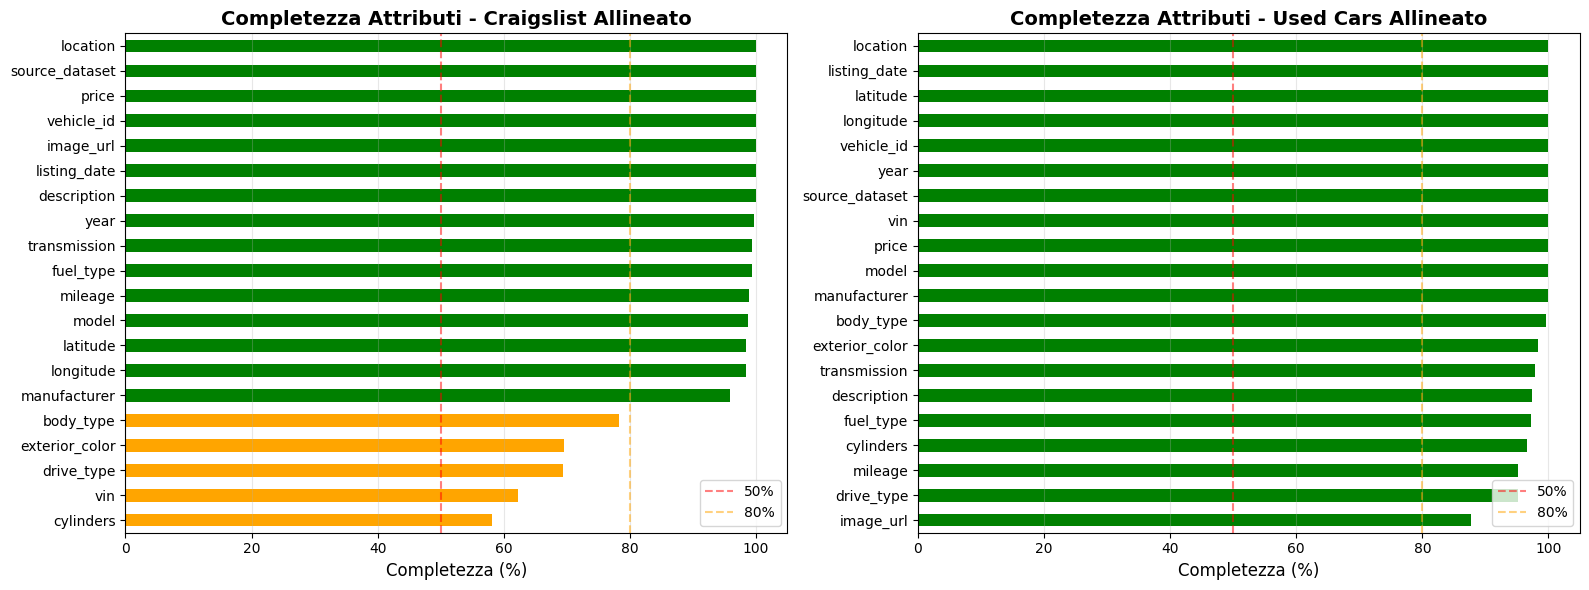

Legenda colori:
  🔴 Rosso: < 50% completezza
  🟠 Arancione: 50-80% completezza
  🟢 Verde: > 80% completezza


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confronto completezza attributi tra i due dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dataset Craigslist
completeness_cr = (df_craigslist_aligned.count() / len(df_craigslist_aligned) * 100).sort_values()
colors_cr = ['red' if x < 50 else 'orange' if x < 80 else 'green' for x in completeness_cr]
completeness_cr.plot(kind='barh', ax=ax1, color=colors_cr)
ax1.set_xlabel('Completezza (%)', fontsize=12)
ax1.set_title('Completezza Attributi - Craigslist Allineato', fontsize=14, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50%')
ax1.axvline(x=80, color='orange', linestyle='--', alpha=0.5, label='80%')
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# Dataset Used Cars
completeness_uc = (df_used_cars_aligned.count() / len(df_used_cars_aligned) * 100).sort_values()
colors_uc = ['red' if x < 50 else 'orange' if x < 80 else 'green' for x in completeness_uc]
completeness_uc.plot(kind='barh', ax=ax2, color=colors_uc)
ax2.set_xlabel('Completezza (%)', fontsize=12)
ax2.set_title('Completezza Attributi - Used Cars Allineato', fontsize=14, fontweight='bold')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50%')
ax2.axvline(x=80, color='orange', linestyle='--', alpha=0.5, label='80%')
ax2.grid(axis='x', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("Legenda colori:")
print("  🔴 Rosso: < 50% completezza")
print("  🟠 Arancione: 50-80% completezza")
print("  🟢 Verde: > 80% completezza")

C:\Users\migli\AppData\Local\Temp\ipykernel_13468\911790008.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Craigslist', 'Used Cars'], patch_artist=True)
C:\Users\migli\AppData\Local\Temp\ipykernel_13468\911790008.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Craigslist', 'Used Cars'], patch_artist=True)
C:\Users\migli\AppData\Local\Temp\ipykernel_13468\911790008.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Craigslist', 'Used Cars'], patch_artist=True)


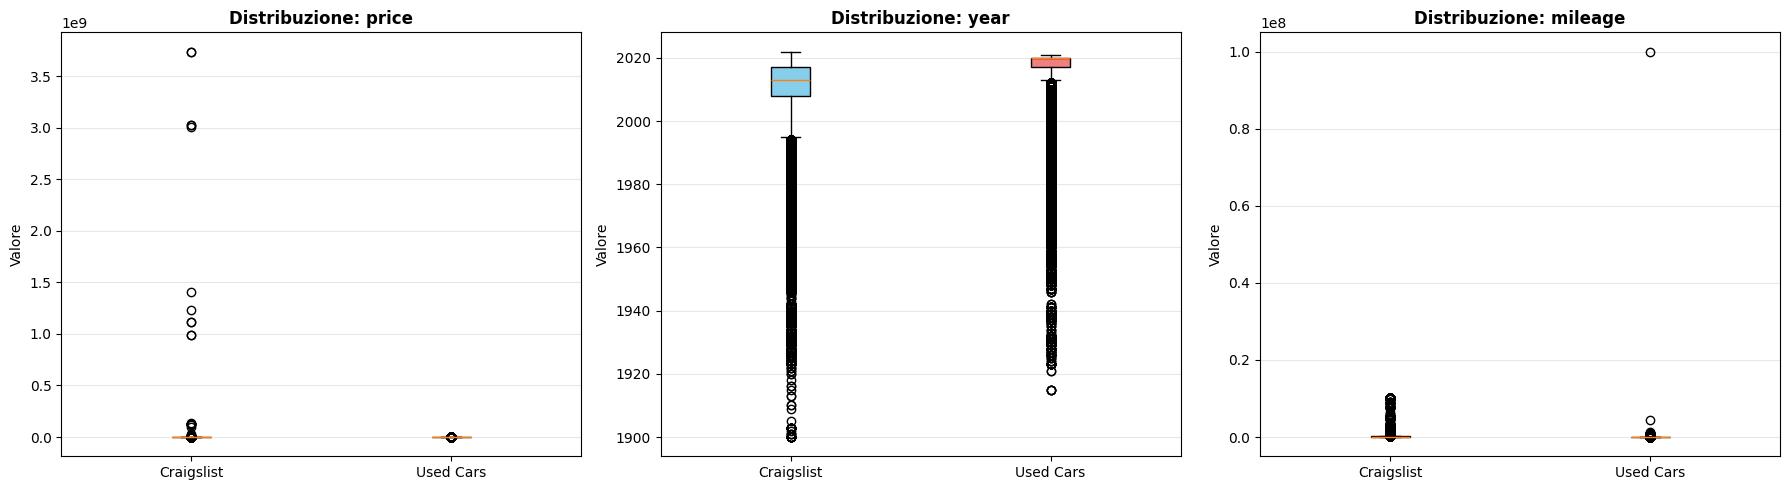


STATISTICHE COMPARATIVE:

PRICE:
  Craigslist - Media: 75,199.03, Mediana: 13,950.00, Std: 12,182,282.17
  Used Cars  - Media: 29,933.37, Mediana: 26,477.00, Std: 19,566.17

YEAR:
  Craigslist - Media: 2,011.24, Mediana: 2,013.00, Std: 9.45
  Used Cars  - Media: 2,017.73, Mediana: 2,020.00, Std: 4.18

MILEAGE:
  Craigslist - Media: 98,043.33, Mediana: 85,548.00, Std: 213,881.50
  Used Cars  - Media: 31,146.90, Mediana: 8,267.00, Std: 74,586.75


In [36]:
# Confronto distribuzione attributi comuni
common_attrs = ['price', 'year', 'mileage']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, attr in enumerate(common_attrs):
    ax = axes[idx]
    
    # Rimuovi valori nulli per la visualizzazione
    cr_data = df_craigslist_aligned[attr].dropna()
    uc_data = df_used_cars_aligned[attr].dropna()
    
    # Box plot affiancati
    data_to_plot = [cr_data, uc_data]
    bp = ax.boxplot(data_to_plot, labels=['Craigslist', 'Used Cars'], patch_artist=True)
    
    # Colora i box
    bp['boxes'][0].set_facecolor('skyblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_title(f'Distribuzione: {attr}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valore', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche descrittive
print("\nSTATISTICHE COMPARATIVE:")
print("=" * 100)
for attr in common_attrs:
    print(f"\n{attr.upper()}:")
    print(f"  Craigslist - Media: {df_craigslist_aligned[attr].mean():,.2f}, "
          f"Mediana: {df_craigslist_aligned[attr].median():,.2f}, "
          f"Std: {df_craigslist_aligned[attr].std():,.2f}")
    print(f"  Used Cars  - Media: {df_used_cars_aligned[attr].mean():,.2f}, "
          f"Mediana: {df_used_cars_aligned[attr].median():,.2f}, "
          f"Std: {df_used_cars_aligned[attr].std():,.2f}")

### Unificazione Schema Finale

Verifichiamo che entrambi i dataset abbiano le stesse colonne e lo stesso ordinamento

In [37]:
# Ottieni lo schema finale usando SOLO gli attributi comuni (intersezione)
# Entrambi i dataset dovrebbero già avere le stesse colonne
final_schema_columns = sorted(list(df_craigslist_aligned.columns.intersection(df_used_cars_aligned.columns)))

print("SCHEMA FINALE UNIFICATO:")
print("=" * 100)
print(f"Totale attributi nello schema finale: {len(final_schema_columns)}")
print(f"\nColonne Craigslist: {len(df_craigslist_aligned.columns)}")
print(f"Colonne Used Cars: {len(df_used_cars_aligned.columns)}")
print(f"Colonne finali unificate: {len(final_schema_columns)}")

# Verifica differenze
cols_only_craigslist = set(df_craigslist_aligned.columns) - set(df_used_cars_aligned.columns)
cols_only_used_cars = set(df_used_cars_aligned.columns) - set(df_craigslist_aligned.columns)

if cols_only_craigslist:
    print(f"\n⚠ Colonne solo in Craigslist: {cols_only_craigslist}")
if cols_only_used_cars:
    print(f"\n⚠ Colonne solo in Used Cars: {cols_only_used_cars}")

# Riordina entrambi i DataFrame per corrispondere allo schema finale
print("\nRiordinamento colonne per uniformità...")
df_craigslist_aligned = df_craigslist_aligned.reindex(columns=final_schema_columns)
df_used_cars_aligned = df_used_cars_aligned.reindex(columns=final_schema_columns)

print("✓ Entrambi i dataset ora hanno le stesse colonne nello stesso ordine")
print(f"\nSchema finale ({len(final_schema_columns)} attributi):")
for i, col in enumerate(final_schema_columns, 1):
    print(f"  {i:2d}. {col}")

SCHEMA FINALE UNIFICATO:
Totale attributi nello schema finale: 20

Colonne Craigslist: 20
Colonne Used Cars: 20
Colonne finali unificate: 20

Riordinamento colonne per uniformità...
✓ Entrambi i dataset ora hanno le stesse colonne nello stesso ordine

Schema finale (20 attributi):
   1. body_type
   2. cylinders
   3. description
   4. drive_type
   5. exterior_color
   6. fuel_type
   7. image_url
   8. latitude
   9. listing_date
  10. location
  11. longitude
  12. manufacturer
  13. mileage
  14. model
  15. price
  16. source_dataset
  17. transmission
  18. vehicle_id
  19. vin
  20. year


## 9. Salvataggio Schema Mediato e Dataset Allineati

Salviamo la definizione dello schema mediato e i dataset allineati con tutte le trasformazioni applicate

In [38]:
import os
import json

# Crea cartella per lo schema
os.makedirs('schema', exist_ok=True)

print("SALVATAGGIO DATASET ALLINEATI E SCHEMA...")
print("=" * 100)

# Salva dataset allineati con schema unificato
print(f"\n1. Salvataggio Craigslist allineato ({len(df_craigslist_aligned):,} righe, {len(df_craigslist_aligned.columns)} colonne)...")
df_craigslist_aligned.to_csv('schema/craigslist_aligned.csv', index=False)
print("   ✓ schema/craigslist_aligned.csv")

print(f"\n2. Salvataggio Used Cars allineato ({len(df_used_cars_aligned):,} righe, {len(df_used_cars_aligned.columns)} colonne)...")
df_used_cars_aligned.to_csv('schema/used_cars_aligned.csv', index=False)
print("   ✓ schema/used_cars_aligned.csv")

# Salva schema finale unificato
print(f"\n3. Salvataggio schema finale ({len(final_schema_columns)} attributi)...")
schema_final_df = pd.DataFrame({
    'Attributo': final_schema_columns,
    'Presente_Craigslist': [col in df_craigslist.columns for col in final_schema_columns],
    'Presente_UsedCars': [col in df_used_cars.columns for col in final_schema_columns],
    'Tipo_Dato': [str(df_craigslist_aligned[col].dtype) for col in final_schema_columns]
})
schema_final_df.to_csv('schema/schema_finale.csv', index=False)
print("   ✓ schema/schema_finale.csv")

# Salva metadati e trasformazioni in JSON
print("\n4. Salvataggio metadati e trasformazioni...")
metadata = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'datasets': {
        'craigslist': {
            'rows': len(df_craigslist_aligned),
            'original_columns': len(df_craigslist.columns),
            'aligned_columns': len(df_craigslist_aligned.columns)
        },
        'used_cars': {
            'rows': len(df_used_cars_aligned),
            'original_columns': len(df_used_cars.columns),
            'aligned_columns': len(df_used_cars_aligned.columns)
        }
    },
    'schema': {
        'total_attributes': len(final_schema_columns),
        'attributes': final_schema_columns
    },
    'transformations_applied': {
        'string_normalization': ['upper', 'title', 'lower', 'strip'],
        'numeric_conversion': ['pd.to_numeric with error handling'],
        'pattern_extraction': ['cylinders extraction', 'state from zip code'],
        'datetime_conversion': ['listing_date to UTC datetime'],
        'boolean_conversion': ['salvage_title', 'has_accidents', 'frame_damaged', 'is_new'],
        'derived_attributes': ['salvage_title from title_status']
    },
    'data_quality': {
        'craigslist_completeness': {
            attr: f"{(df_craigslist_aligned[attr].count() / len(df_craigslist_aligned) * 100):.1f}%"
            for attr in final_schema_columns
        },
        'used_cars_completeness': {
            attr: f"{(df_used_cars_aligned[attr].count() / len(df_used_cars_aligned) * 100):.1f}%"
            for attr in final_schema_columns
        }
    }
}

with open('schema/metadata_allineamento.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print("   ✓ schema/metadata_allineamento.json")

# Genera report di riepilogo
print("\n5. Generazione report di riepilogo...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f'schema/report_allineamento_{timestamp}.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 100 + "\n")
    f.write("REPORT ALLINEAMENTO DATASET ALLO SCHEMA MEDIATO\n")
    f.write(f"Generato il: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 100 + "\n\n")
    
    f.write("DATASET ALLINEATI:\n")
    f.write("-" * 100 + "\n")
    f.write(f"Craigslist: {len(df_craigslist_aligned):,} righe × {len(df_craigslist_aligned.columns)} colonne\n")
    f.write(f"Used Cars: {len(df_used_cars_aligned):,} righe × {len(df_used_cars_aligned.columns)} colonne\n")
    f.write(f"Schema finale unificato: {len(final_schema_columns)} attributi\n\n")
    
    f.write("TRASFORMAZIONI APPLICATE:\n")
    f.write("-" * 100 + "\n")
    f.write("- Normalizzazione stringhe: .upper(), .title(), .lower(), .strip()\n")
    f.write("- Conversione tipi numerici: pd.to_numeric() con errors='coerce'\n")
    f.write("- Estrazione pattern: numero cilindri, stati da zip code\n")
    f.write("- Conversione datetime: UTC-aware timestamps\n")
    f.write("- Attributi booleani: salvage_title, has_accidents, frame_damaged, is_new\n")
    f.write("- Attributi derivati: salvage_title da title_status\n\n")
    
    f.write("SCHEMA FINALE (ALFABETICO):\n")
    f.write("-" * 100 + "\n")
    for i, col in enumerate(final_schema_columns, 1):
        in_cr = '✓' if col in df_craigslist.columns else '✗'
        in_uc = '✓' if col in df_used_cars.columns else '✗'
        f.write(f"{i:2d}. {col:35s}  Craigslist: {in_cr}  Used Cars: {in_uc}\n")

print(f"   ✓ schema/report_allineamento_{timestamp}.txt")

print("\n" + "=" * 100)
print("COMPLETATO!")
print("=" * 100)
print("\nFile generati:")
print("  📁 schema/craigslist_aligned.csv - Dataset Craigslist allineato e pulito")
print("  📁 schema/used_cars_aligned.csv - Dataset Used Cars allineato e pulito")
print("  📁 schema/schema_finale.csv - Definizione schema finale unificato")
print("  📁 schema/metadata_allineamento.json - Metadati e statistiche complete")
print(f"  📁 schema/report_allineamento_{timestamp}.txt - Report testuale dettagliato")
print("\nI dataset sono ora pronti per l'integrazione e l'analisi avanzata!")

SALVATAGGIO DATASET ALLINEATI E SCHEMA...

1. Salvataggio Craigslist allineato (426,880 righe, 20 colonne)...
   ✓ schema/craigslist_aligned.csv

2. Salvataggio Used Cars allineato (3,000,040 righe, 20 colonne)...
   ✓ schema/used_cars_aligned.csv

3. Salvataggio schema finale (20 attributi)...
   ✓ schema/schema_finale.csv

4. Salvataggio metadati e trasformazioni...
   ✓ schema/metadata_allineamento.json

5. Generazione report di riepilogo...
   ✓ schema/report_allineamento_20260202_095958.txt

COMPLETATO!

File generati:
  📁 schema/craigslist_aligned.csv - Dataset Craigslist allineato e pulito
  📁 schema/used_cars_aligned.csv - Dataset Used Cars allineato e pulito
  📁 schema/schema_finale.csv - Definizione schema finale unificato
  📁 schema/metadata_allineamento.json - Metadati e statistiche complete
  📁 schema/report_allineamento_20260202_095958.txt - Report testuale dettagliato

I dataset sono ora pronti per l'integrazione e l'analisi avanzata!


## 10. Riepilogo Completo Allineamento

### Schema Finale Unificato

Lo schema finale contiene **tutti gli attributi** di entrambi i dataset, normalizzati e puliti.

**Trasformazioni Applicate**:
- ✓ **Normalizzazione stringhe**: `.upper()` per VIN, `.title()` per nomi, `.lower()` per categorie
- ✓ **Pulizia spazi**: `.strip()` su tutti i campi testuali
- ✓ **Conversione tipi**: `pd.to_numeric()` con gestione errori per numerici
- ✓ **Estrazione pattern**: numero cilindri da "6 cylinders", stati da zip code
- ✓ **Date UTC**: conversione a datetime UTC-aware
- ✓ **Booleani**: conversione esplicita per flags
- ✓ **Attributi derivati**: `salvage_title` da `title_status`

### Categorizzazione Attributi (SOLO COMUNI)

**Identificatori** (3):
- vehicle_id, vin, source_dataset

**Informazioni Base** (4):
- price, year, manufacturer, model

**Caratteristiche Tecniche** (5):
- mileage, fuel_type, transmission, drive_type, cylinders

**Caratteristiche Fisiche** (2):
- body_type, exterior_color

**Informazioni Geografiche** (3):
- latitude, longitude, location

**Informazioni Listing** (3):
- listing_date, description, image_url

**Totale**: 20 attributi comuni tra i due dataset

### Gestione Memoria

- **Craigslist**: Processing diretto (~427k righe)
- **Used Cars**: Processing in chunk da 500k righe (~3M righe totali)

### Qualità dei Dati

I dataset allineati mantengono:
- Valori originali per attributi presenti
- `None`/`NaN` per attributi non disponibili nel dataset originale
- Tipi di dati consistenti tra i due dataset
- Ordine colonne identico per entrambi i dataset

### Output Generati

- **craigslist_aligned.csv**: Dataset Craigslist pulito e normalizzato
- **used_cars_aligned.csv**: Dataset Used Cars pulito e normalizzato
- **schema_finale.csv**: Definizione completa dello schema unificato
- **metadata_allineamento.json**: Metadati, trasformazioni e statistiche qualità
- **report_allineamento_*.txt**: Report testuale dettagliato con timestamp

### Prossimi Passi Suggeriti

1. **Data Cleaning Avanzato**:
   - Rimozione outlier (prezzi anomali, anni impossibili)
   - Standardizzazione nomi produttori/modelli
   - Gestione valori mancanti con strategie appropriate

2. **Feature Engineering**:
   - Calcolo età veicolo da anno
   - Categorie prezzo (economico, medio, premium)
   - Rapporti consumo città/autostrada
   - Indicatori qualità (presenza incidenti + frame damage)

3. **Integrazione Dataset**:
   - Merge dei due dataset allineati
   - Deduplica basata su VIN
   - Aggregazione statistiche per produttore/modello

4. **Analisi e Modeling**:
   - Price prediction
   - Clustering veicoli simili
   - Analisi mercato geografico
